<a href="https://colab.research.google.com/github/meriemdouider1/2/blob/main/resnet%20v2%20sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation des packages :

In [97]:
import json
import math
import os
import cv2
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model



Tout d'abord, récupérons l'ensemble de données Glaucoma Positive contre Glaucoma négative en utilisant kaggle

In [98]:
! pip install -q kaggle

In [99]:
from google.colab import files

In [100]:
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"meryemdouider","key":"71abdf1b37f401d9b4f539d2b43177eb"}'}

In [101]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "sshikamaru/glaucoma-detection"

kaggle.json
 90% 169M/188M [00:03<00:00, 62.0MB/s]
100% 188M/188M [00:03<00:00, 60.1MB/s]


In [102]:
!unzip glaucoma-detection.zip

Archive:  glaucoma-detection.zip
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/002.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/003.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/004.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/005.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/006.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/007.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/008.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/009.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/010.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glauc

Préparation des données entraînement /test / validation :

In [103]:
DATAGlua_Train = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
DATAGlua_Test = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'


notre jeu deux de données est divisé en deux partie :

1.   des données avec un Gluacoma_positive
2.   des données avec un Gluacoma_négative



In [104]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATAGlua_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['Glaucoma_Positive', 'Glaucoma_Negative']


Division l'ensemble de données d'entraînement en x_train_data et y_train_data : (x_train_data : 'les images' , y_train_data : 'label / catégorie ')

In [105]:
x_train_data = []
y_train_data = []
IMG_SIZE=224
def creation_train_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
creation_train_data()

In [106]:
x_test_data = []
y_test_data = []
IMG_SIZE=224
def creation_test_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
creation_test_data ()

In [107]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.05, random_state=1)

In [108]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [109]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

# **Transfer learning**

# Création du modèle:

# **inception_resnet_v2**


Inception-ResNet-v2 est une architecture neuronale convolutionnelle qui s'appuie sur la famille d'architectures Inception . nception-ResNet-v2 est un réseau neuronal est formé sur plus d'un million d'images de la base de données ImageNet . Le réseau comprend plusieurs couches de profondeur et peut classer les images en 1000 catégories d'objets .
https://keras.io/api/applications/inceptionresnetv2/

In [110]:
IMG_SHAPE = (224, 224,3)

importer le modèle pré-entraîne inception_resnet_v2:

In [111]:
from tensorflow.keras.applications import inception_resnet_v2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten

In [112]:
base_model3 = inception_resnet_v2.InceptionResNetV2

base_model3 = base_model3(weights='imagenet', include_top=False)

affichage les layer du modèle resnet-v2 et Figer le modèle pré-entraine en utilisant la commande layer.trainable = False

In [113]:
for layer in base_model3.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(base_model3.layers))

input_3
conv2d_406
batch_normalization_406
activation_406
conv2d_407
batch_normalization_407
activation_407
conv2d_408
batch_normalization_408
activation_408
max_pooling2d_8
conv2d_409
batch_normalization_409
activation_409
conv2d_410
batch_normalization_410
activation_410
max_pooling2d_9
conv2d_414
batch_normalization_414
activation_414
conv2d_412
conv2d_415
batch_normalization_412
batch_normalization_415
activation_412
activation_415
average_pooling2d_2
conv2d_411
conv2d_413
conv2d_416
conv2d_417
batch_normalization_411
batch_normalization_413
batch_normalization_416
batch_normalization_417
activation_411
activation_413
activation_416
activation_417
mixed_5b
conv2d_421
batch_normalization_421
activation_421
conv2d_419
conv2d_422
batch_normalization_419
batch_normalization_422
activation_419
activation_422
conv2d_418
conv2d_420
conv2d_423
batch_normalization_418
batch_normalization_420
batch_normalization_423
activation_418
activation_420
activation_423
block35_1_mixed
block35_1_conv


In [114]:
base_model3.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, None, None, 3 96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, None, None, 3 0           batch_normalization_406[0][0]    
________________________________________________________________________________


Création d'un nouveau modèle qui va se baser sur les résultas du modèle pré-entraîne :

nous utilisons plusieurs layer : Global MaxPooling2d / dense  , et comme un optimizer nous avons testé plusieurs optimizer (sgd /adam ) , mais l'optimizer qui a donnée le meilleur résultat

In [115]:
x = base_model3.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(2, activation='sigmoid')(x)


model3 = Model(base_model3.input, x)
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [116]:

model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, None, None, 3 96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, None, None, 3 0           batch_normalization_406[0][0]    
____________________________________________________________________________________________


une étape importante avant d'entrainer le modèle est la normalisation pour mettre à l'échelle les valeurs d'entrée (initialement dans la plage [0, 255]) à la plage [0, 1]. cette normalisation est effectuée en utilisant la fonction ImageDataGenerator . catte fonction va nous permis de normaliser les données d'entrée test et validation. cette fonction est utilisable aussi pour l'augmentation des données .



In [117]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

Augmentation et normalisation du données test :

In [118]:
train_datagen.fit(X_Train)


normalisation du données de validation :

In [119]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen.fit(X_Val)

Entraînement du modèle avec des layers du modèle pré-entrâine ( en mode freeze)

In [120]:
train_model  = model3.fit(X_Train, Y_Train, batch_size=64, epochs=10,
                    validation_data=(X_Val, Y_Val))

Epoch 1/10
8/8 [==============================] - 16s 930ms/step - loss: 97615.4847 - accuracy: 0.4859 - val_loss: 0.4542 - val_accuracy: 0.8462
Epoch 2/10
8/8 [==============================] - 3s 345ms/step - loss: 0.6279 - accuracy: 0.7576 - val_loss: 0.6918 - val_accuracy: 0.8462
Epoch 3/10
8/8 [==============================] - 3s 348ms/step - loss: 0.6920 - accuracy: 0.7411 - val_loss: 0.6908 - val_accuracy: 0.8462
Epoch 4/10
8/8 [==============================] - 3s 352ms/step - loss: 0.6913 - accuracy: 0.7423 - val_loss: 0.6896 - val_accuracy: 0.8462
Epoch 5/10
8/8 [==============================] - 3s 353ms/step - loss: 0.6906 - accuracy: 0.7299 - val_loss: 0.6884 - val_accuracy: 0.8462
Epoch 6/10
8/8 [==============================] - 3s 359ms/step - loss: 0.6898 - accuracy: 0.7297 - val_loss: 0.6871 - val_accuracy: 0.8462
Epoch 7/10
8/8 [==============================] - 3s 358ms/step - loss: 0.6883 - accuracy: 0.7706 - val_loss: 0.6858 - val_accuracy: 0.8462
Epoch 8/10
8/8 

# fine-tuning

dégelons maintenant le modèle de base et formons l'ensemble du modèle de bout en bout avec un faible taux d'apprentissage.

Il est important de noter que bien que le modèle de base devienne entraînable, il fonctionne toujours en mode inférence puisque nous avons passé training = False lors de son appel lorsque nous avons construit le modèle.

In [121]:
for layer in model3.layers :
   layer.trainable = True
 

In [122]:
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [123]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, None, None, 3 96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, None, None, 3 0           batch_normalization_406[0][0]    
____________________________________________________________________________________________

In [124]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [125]:
train_model  = model3.fit(X_Train, Y_Train, batch_size=64, epochs=10,
                    validation_data=(X_Val, Y_Val))

Epoch 1/10
8/8 [==============================] - 28s 2s/step - loss: 0.7121 - acc: 0.3673 - val_loss: 0.6224 - val_acc: 0.8077
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 0.7005 - acc: 0.4543 - val_loss: 0.5757 - val_acc: 0.8462
Epoch 3/10
8/8 [==============================] - 9s 1s/step - loss: 0.6819 - acc: 0.6003 - val_loss: 0.5618 - val_acc: 0.8462
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.6667 - acc: 0.6844 - val_loss: 0.5565 - val_acc: 0.8462
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 0.6524 - acc: 0.7132 - val_loss: 0.5545 - val_acc: 0.8462
Epoch 6/10
8/8 [==============================] - 9s 1s/step - loss: 0.6375 - acc: 0.7345 - val_loss: 0.5447 - val_acc: 0.8462
Epoch 7/10
8/8 [==============================] - 9s 1s/step - loss: 0.6174 - acc: 0.7650 - val_loss: 0.5243 - val_acc: 0.8462
Epoch 8/10
8/8 [==============================] - 9s 1s/step - loss: 0.6140 - acc: 0.7409 - val_loss: 0.5138 -

**Test :**

In [126]:
loss_val, acc_val = model3.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1/1 [==============================] - 0s 152ms/step - loss: 0.4924 - acc: 0.8462
Validation: accuracy = 0.846154  ;  loss_v = 0.492354


In [127]:
y_test_data = to_categorical(y_test_data)
loss_test, acc_test = model3.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

5/5 [==============================] - 1s 206ms/step - loss: 0.5807 - acc: 0.7385
Test: accuracy = 0.738462  ;  loss = 0.580732


In [128]:
model3.save("Incep_ResNet_v2.h5")

Text(0.5, 1.0, 'Training and validation loss')

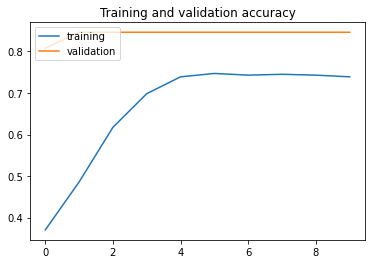

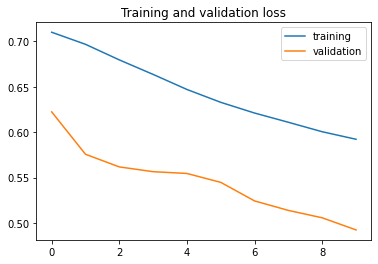

In [129]:

acc = train_model.history['acc']
val_acc = train_model.history['val_acc']


loss = train_model.history['loss']
val_loss = train_model.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')